# Analysis of Connecticut Town Data
This project brings together various collections of data regarding towns in Connecticut over the past decade. The data comes from the CTdata Collaborative, which can be found [here](https://www.ctdata.org/data-by-topic). The data used in this analysis comes from several files and was pulled together by the scripts found in the Data-Sources folder. Simply put, those scripts selected certain columns from within a dataset and copied them over to a common table. In general, the data is an average of the statistics of the past 10 years, with features surrounding the following topics:
- Demographics
- Family Makeup
- Wealth
- Education
- Healthcare
- Crime

---
## Set-Up
To begin, several librarys need to be imported. Here, pandas and numpy are used to handle data, and bokeh and seaborn are used to display plots.

In [42]:
import pandas as pd
import numpy as np
import csv
from bokeh.plotting import figure
from bokeh.io import output_notebook, show
from bokeh.models import ColumnDataSource, HoverTool
import seaborn as sns
import pandas as pd
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import numpy as np
output_notebook()

Loading BokehJS ...

Now the data can be loaded in from TownData.csv. Once loading in the data, it is centered, by subtracting the mean of every column. The town names and headers are also pulled from the sheed here.

In [63]:
data = np.genfromtxt('TownData.csv', delimiter=',',skip_header=1)
data = data[:,2:]   # cut row indices and town names

#Center the data
data_centered = data - np.mean(data, axis=0)
data_centered = data_centered/np.std(data, axis=0)

# Get Header Row and Town Names
with open('TownData.csv') as f:
    reader = csv.reader(f)
    feature_names = list(next(reader))[2:]
    town_names = []
    for row in reader:
        town_names.append(row[1])


---
## PCA Analysis
Here a PCA of the data is performed using numpy. Before the PCA is computed, a Pair Grid is generated.

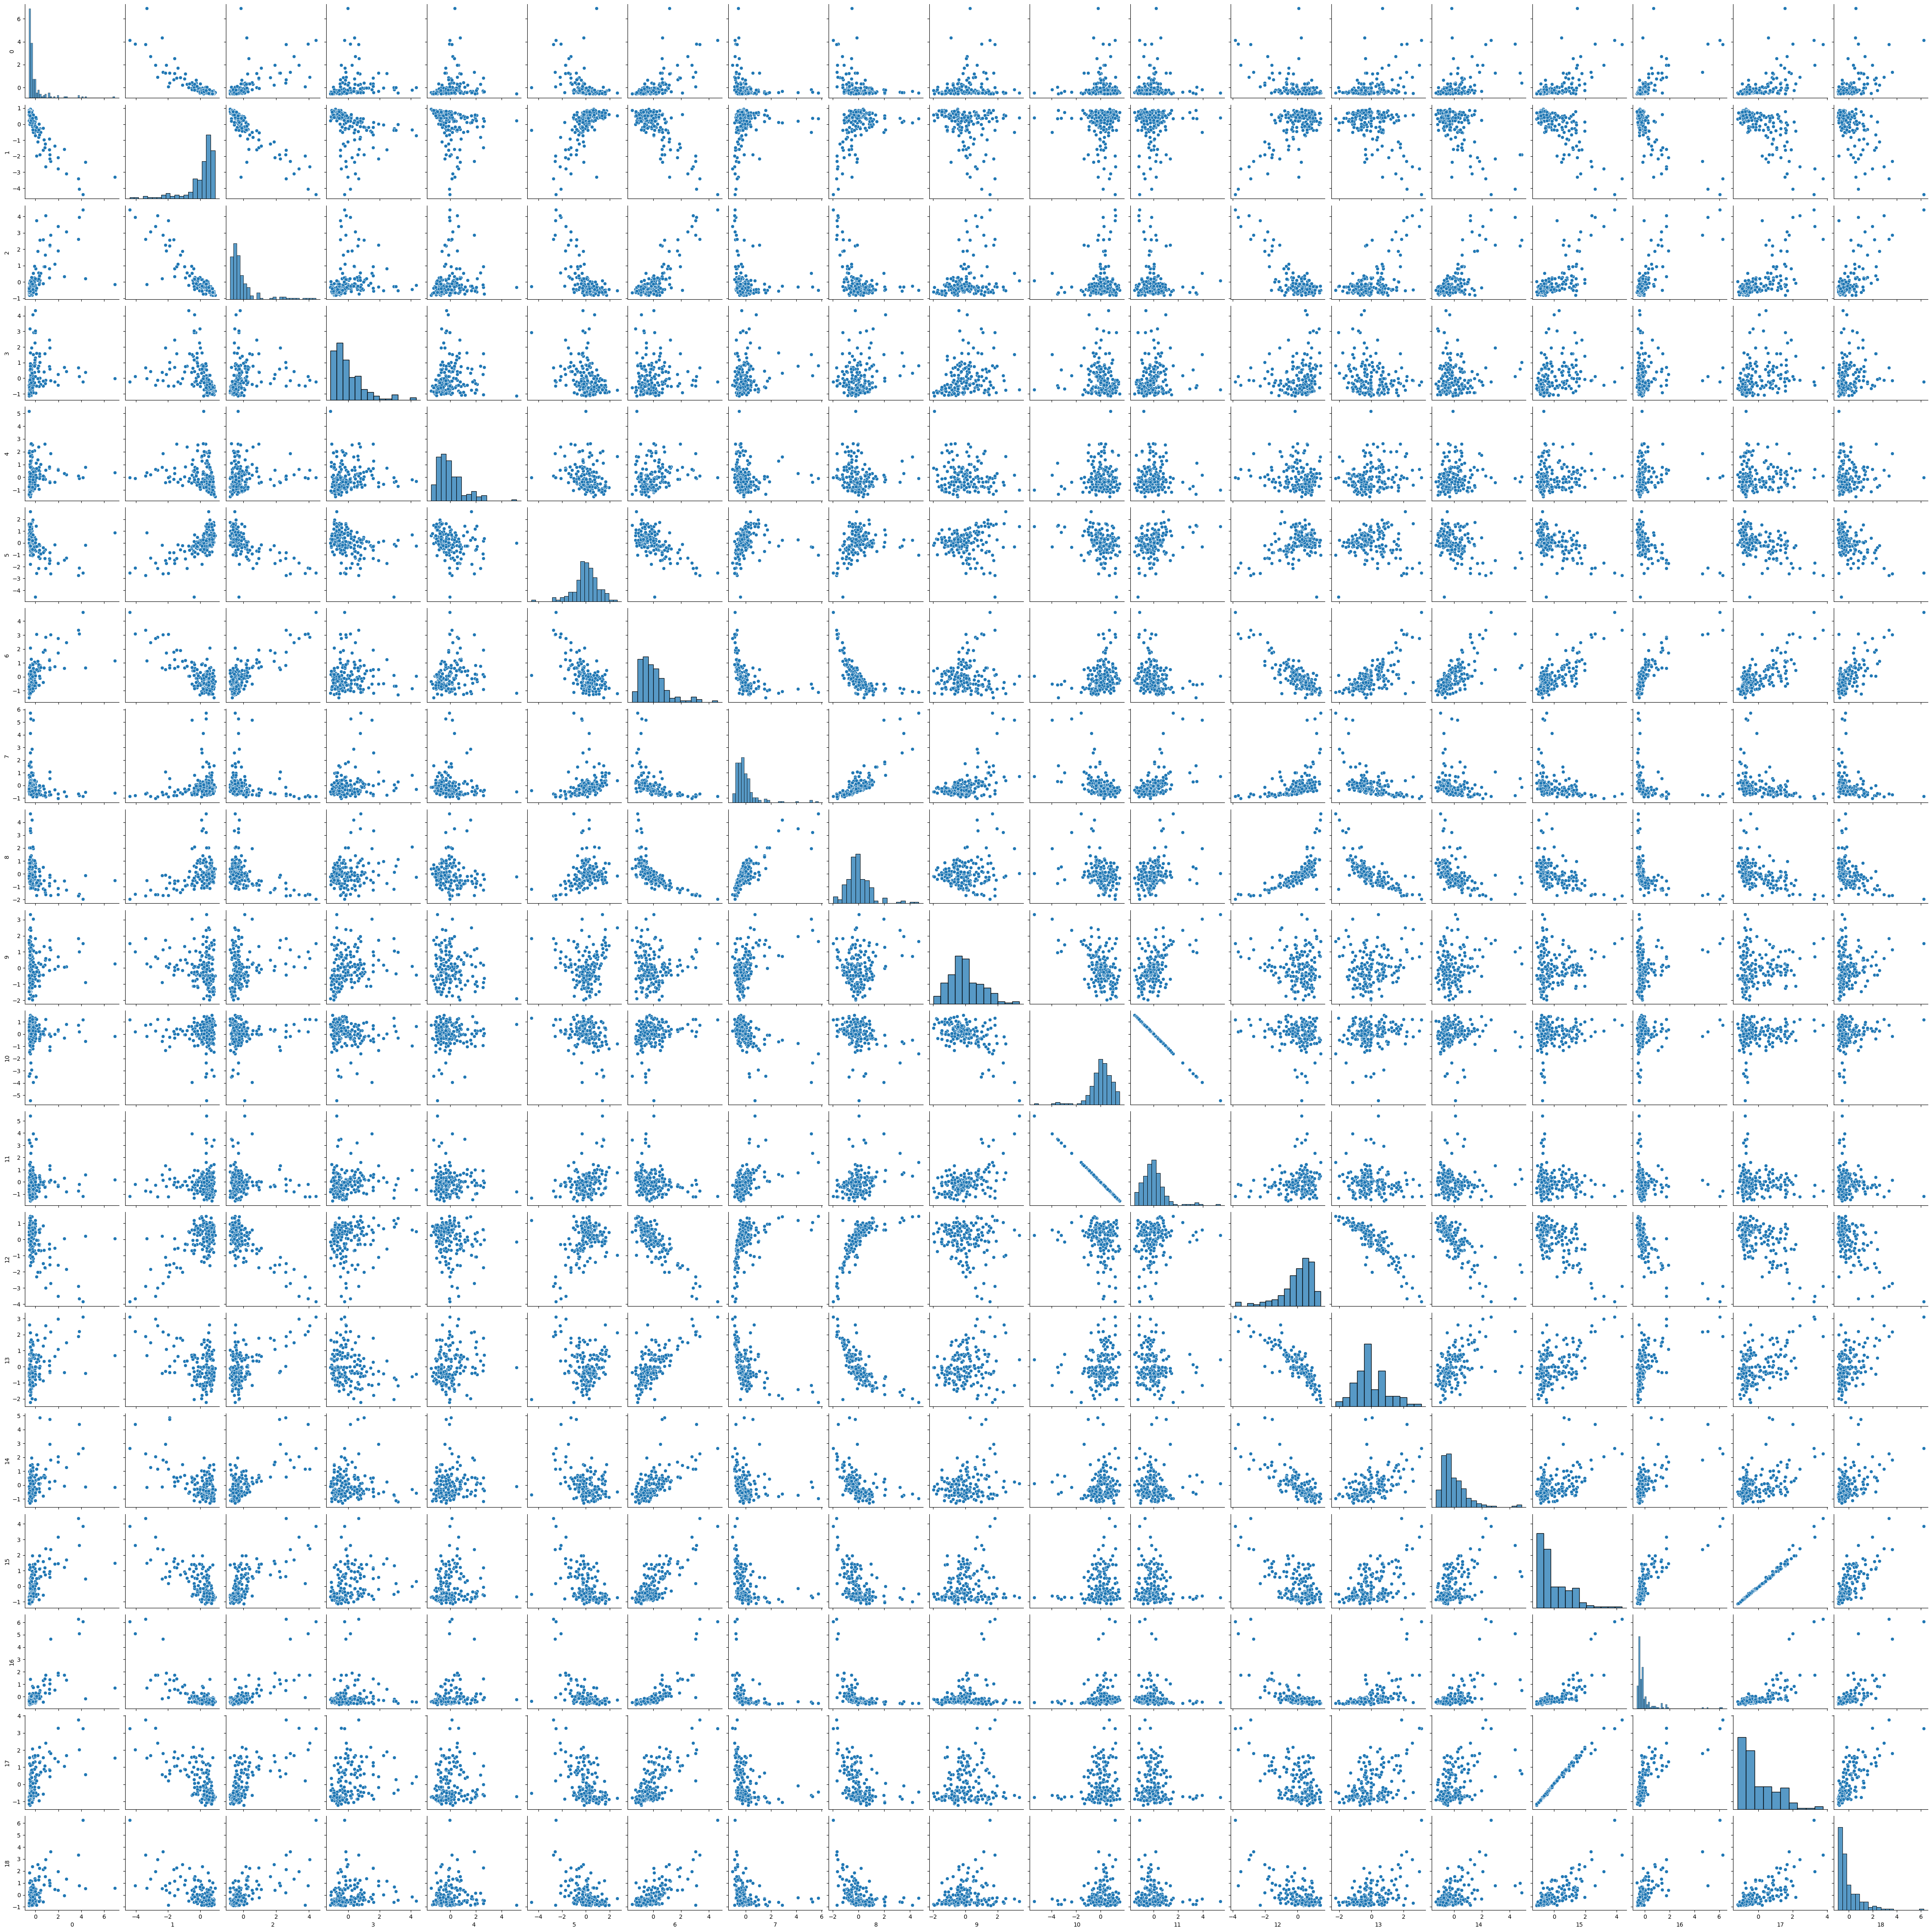

In [20]:
sns.pairplot(pd.DataFrame(data_centered))

---
### Computing the Principal Components
The PCA is now computed below. In this calculation, D is the covariance matrix, L is the list of eigenvalues and P is a matrix of eigenvectors. Since np.linalg function generates these in increasing order, the lists are reversed to place the greated eigenvectors and eigenvalues at the front. PC is the principal compenent array, a 2xn matrix where the columns are the principals componenets.

In [39]:
D = np.dot(data_centered.transpose(), data_centered)/data.shape[0]

L, P = np.linalg.eigh(D)
L = L[::-1]
P = P[:,::-1]
PC = np.dot(data_centered, P[:,:2])


### Graphing
Now the principal components are graphed on a scatterplot below. Note that the plot has a hover tool available to inspect individual points and displays the loading lines of the feature vectors in the center of the data. The lines are sized according to how prominantly, and in what direction, the feature influences the prinicpal components.

In [74]:

# Create Column Data Source Object
source = ColumnDataSource({'pc0':PC[:,0],'pc1':PC[:,1], 'town':town_names,'AfricanAmerican': data[:,0], "White": data[:,1], "Hispanic":data[:,2], "Asian": data[:,3], "Two+Races":data[:,4], "MedianAge":data[:,5], "SingleParent":data[:,6],"MedianHomeValue":data[:,7],"MedianHouseholdIncome":data[:,8],"GiniRatio":data[:,9],"PublicSchoolEnrollment":data[:,10],"PrivateSchoolEnrollment":data[:,11],"withPrivateHealthcare":data[:,12],"withPublicHealthcare":data[:,13],"withoutHealthcare":data[:,14],"TotalCrimeIndexper100k":data[:,15],"TotalViolentCrimeper100k":data[:,16], "TotalPropertyCrimeper100k":data[:,17],"DrugArrestsper10k":data[:,18]})

# Create the Figure and scatter that data
pca_with_loadings = figure(title="Pincipal Components with Loadings", width=1200, height = 800)
pca_with_loadings.scatter(x='pc0', y='pc1', source=source)

#Create Loading Lines
colors = ['#FF0202','#FF8000', '#952F00', '#FF7674', '#BB6D57', '#00FEE3', '#FEF200', '#13B700', '#0A5A01', '#1AFF00', '#FF00FB', '#780076', '#000CFF', '#000790', '#8D93FF', '#C8C8C8', '#888888', '#515151', '#000000']
for i in range(19):
    pca_with_loadings.line(x=[0,P[i,0]], y=[0,P[i,1]], color=colors[i],line_width=2,legend_label=feature_names[i])
pca_with_loadings.legend.title="Loading Line Labels"

#Allow Hovering
pca_with_loadings.add_tools(
    HoverTool(
        tooltips=[
            ("Town","@town"),
            ('% African American', "@AfricanAmerican{0.00}"),
            ("% White", "@White{0.00}"), 
            ("% Hispanic", "@Hispanic{0.00}"), 
            ("% Asian", "@Asian{0.00}"), 
            ("Median Age", "@MedianAge{0.00}"), 
            ("% Single Parent Families", "@SingleParent{0.00}"), 
            ("Median Home Value", "@MedianHomeValue{$0,0,0.00}"),
            ("Median Household Income","@MedianHouseholdIncome{$0,0,0.00}"),
            ("Gini Ratio","@GiniRatio{0.00}"),
            ("% Public School Enrollment","@PublicSchoolEnrollment{0.00}"),
            ("% Private School Enrollment","@PrivateSchoolEnrollment{0.00}"),
            ("% with Private Healthcare","@withPrivateHealthcare{0.00}"),
            ("% with Public Healthcare","@withPublicHealthcare{0.00}"),
            ("% without Healthcare","@withoutHealthcare{0.00}"),
            ("Total Crime Index per 100k","@TotalCrimeIndexper100k{0,0.00}"),
            ("Total Violent Crime per 100k","@TotalViolentCrimeper100k{0,0.00}"),
            ("Total Property Crime per 100k","@TotalPropertyCrimeper100k{0,0.00}"),
            ("Drug Arrests per 10k","@DrugArrestsper10k")
            ]))

show(pca_with_loadings)

### Analysis
Beginning with an analysis of the loading lines, some things are quite obvious, such as Public & Private school enrollment being completely opposed, as well as Public & Private healthcare eing opposed. Demographic Makeups are also quite opposed, where more of a minority presence tends to go against a white majority presence. Economic factors however, such as gini ratio, Median Home Value, and Median Household Income tend seem to largely independent of town demographics, although Median Home Income tends to correspond to a town with a higher makeup of white people, and a high gini ratio, meaning more economic inequality, tends to be present in towns with a higher percentage of minority groups. Public vs Private school enrollment is almost entirely independent of a towns demographic. The most interesting trends seen in the loading lines comes in healthcare and crime. Private Health insurance seems to be correlated to the amount of white people in a town, whereas no healthcare lines almost directly with the Hispanic and African American loading lines. Crime lines, such as Total Crime per 100k and Drug Arrests also tend to line up with the demographics of a town, where crimes lines tend to align with minority group lines. It is important to also note that crime lines run slightly in accordance with wealth inequality (Gini Ratio) and against median household income. Median age is also almost directly aligned with private health insurance.

Looking at the graph as a whole, one can make observations about Connecticut as whole. One can see that towns in Connecticut tend to be white and wealthy. Towns that have high reputations, such as Greenwich, Hartford, Bridgeport, and Waterbury are also outliers on this graph. One can also see that towns in Connecticut tend to spread along a wealth distribution, where crime and healthcare tend to be worse in areas with worse economic conditions and better in areas with better economic conditions.

# Logistic Regression Analysis

The Gini index, or Gini co-efficient, measures income distribution across a population. And a higher Gini index indicates greater inequality, with high-income individuals receiving much larger percentages of the population’s total income [Investopedia]. The purpose of this part of the project is to understand/determine what chacateristics of a town contribute the most to income inequaitly as measured by the Gini Ratio.

---

First I am going to read in the dataset

In [2]:
df = pd.read_csv("TownData.csv")

The `Index` Column and `Town` won't be of use for a few reasons. Since Town is a unique value in this dataset and it is categorial, working with it means encoding it. And methods like One Hot Encoding would introduce many many columns into the dataset.

In [3]:
df.drop(['Index'], axis=1, inplace=True)
df.drop(["Town"], axis=1, inplace=True)

A Gini Ratio of `>=` 0.5 is encoded as a `1` and `0` otherwise

In [4]:
df["High Income Inequality"] = df["Gini Ratio"].apply(lambda x: 1 if x >= 0.5 else 0)

We no longer need the `Gini Ratio` column

In [5]:
df.drop(["Gini Ratio"], axis=1, inplace=True)

In the dataset we have `17` towns which which show high income inequality and `153` towns which show low income equality

In [6]:
sum(df["High Income Inequality"] == 1), sum(df["High Income Inequality"] == 0) 

(17, 153)

The data is being split into `X` which is all the features but the `High Income Inequality` columns and `y` is the `High Income Inequality` columns tha we are going to predict

In [43]:
X = df.iloc[:, 0:-1]
y = df.iloc[:, -1]

Next we split the data into a training and testing dataset

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=True)

The features in this dataset take on a wide range of values, so to make the convergence of the algorthim quicker and faster, the data is being standardized to bring all the features down to the same scale.

Note: When standardizing the data, it is important to fit it to the training data and then use the same scaler to transform the test data since this data should be treated as data the model will see later but not yet.

In [45]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Here we train the model

In [46]:
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

From the following two cells, `Median Home Value` is the most important predictor of income inequality indicating that towns with high home values demonstates more income inequality. 

In fact the following article "The Geography of Inequality: How Land Use Regulation Produces Segregation" argued that land use regulations in high-income areas tend to drive up housing prices and exclude low-income residents, leading to greater income inequality. This model more or less supports this.


https://www.cambridge.org/core/journals/american-political-science-review/article/geography-of-inequality-how-land-use-regulation-produces-segregation/BAB4ABDF014670550615CE670FF66016

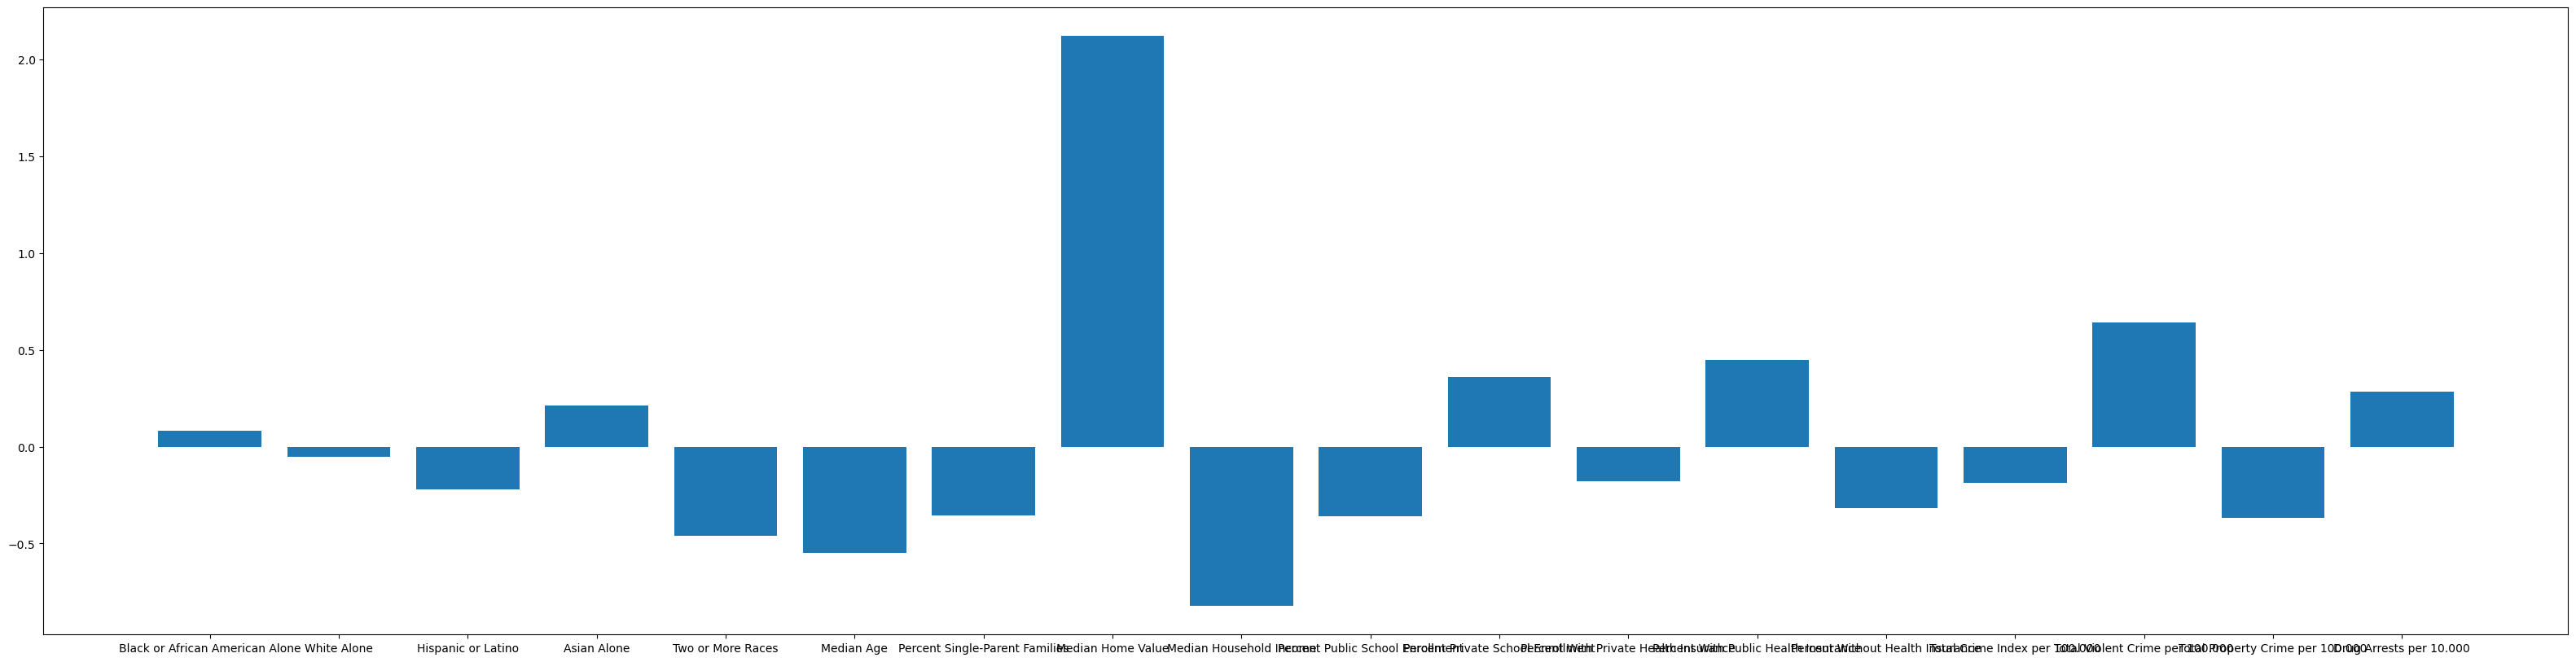

In [47]:
plt.figure(figsize=(40, 10))
plt.bar(df.iloc[:, 0:-1].columns, model.coef_.ravel())
plt.show()

In [48]:
pd.DataFrame(data={'Columns': df.iloc[:, 0:-1].columns, 'Importance': model.coef_.ravel()})

,Columns,Importance
0,Black or African American Alone,0.083768
1,White Alone,-0.052222
2,Hispanic or Latino,-0.221273
3,Asian Alone,0.213834
4,Two or More Races,-0.459526
5,Median Age,-0.547519
6,Percent Single-Parent Families,-0.355588
7,Median Home Value,2.120384
8,Median Household Income,-0.822962
9,Percent Public School Enrollment,-0.360471


In [50]:
y_pred = model.predict(X_test)

To evaluate the model a confustion matrix was used

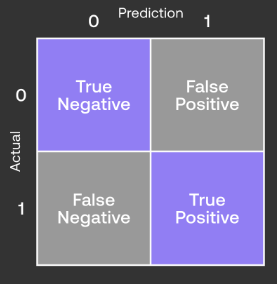

In [51]:
cm = confusion_matrix(y_test, y_pred)
cm

array([[55,  1],
       [ 0,  1]], dtype=int64)

In [52]:
tn, fp, fn, tp = cm.ravel()
tn, fp, fn, tp

(55, 1, 0, 1)

Accuracy: $(TP + TN) / (TP + TN + FP + FN)$ The proortion of correctly predicted positives and negatives with respect to the entire dataset

Precision: $TP / (TP + FP)$ the proportion of true positives out of all positive predictions. A high precision means that the model is good at not making any false positives.

Recall: $TP / (TP + FN)$ the proportion of true positives out of all actual positives. A high recall means that the model is good at not making false negatives.

F1 score: $2 * (precision * recall) / (precision + recall)$ is a measure of both the  precision and recall. So it is a good measure of both how good the model is at avoiding false positive and false negatives

In [53]:
pd.DataFrame(data={
    'Evaluation Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score'],
    'Value': [ (tp+tn)/(tp+fp+fn+tn), tp/(tp+fp), tp/(tp+fn),  (2*tp/(tp+fp))*(tp/(tp+fn)) / ((tp/(tp+fp))+(tp/(tp+fn)))]
})

,Evaluation Metric,Value
0,Accuracy,0.982456
1,Precision,0.500000
2,Recall,1.000000
3,F1 Score,0.666667


Note: Since data is very imbalanced this creates a bias for these metrics.